In [1]:
import os
import zipfile
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras import layers
from shutil import copyfile

print(tf.__version__)

2.8.2


In [2]:
ACC_THRESHOLD = 0.84

##Downloading & Loading Data

Code below is for directory management

In [3]:
!gdown 1RlgoTZo6erR9i_qYkuA2IiBE-UrZjHSR

Downloading...
From: https://drive.google.com/uc?id=1RlgoTZo6erR9i_qYkuA2IiBE-UrZjHSR
To: /content/skin-90.zip
100% 95.7M/95.7M [00:00<00:00, 135MB/s]


In [4]:
! unzip skin-90.zip

Archive:  skin-90.zip
  inflating: skin-90/Test/Dermatitis perioral/d64.jpg  
  inflating: skin-90/Test/Dermatitis perioral/d65.jfif  
  inflating: skin-90/Test/Dermatitis perioral/d66.jpg  
  inflating: skin-90/Test/Dermatitis perioral/d67.jpg  
  inflating: skin-90/Test/Dermatitis perioral/d68.jfif  
  inflating: skin-90/Test/Dermatitis perioral/d69.jfif  
  inflating: skin-90/Test/Dermatitis perioral/d70.JPG  
  inflating: skin-90/Test/Eksim/e64.JPG  
  inflating: skin-90/Test/Eksim/e65.JPG  
  inflating: skin-90/Test/Eksim/e66.JPG  
  inflating: skin-90/Test/Eksim/e67.JPG  
  inflating: skin-90/Test/Eksim/e68.JPG  
  inflating: skin-90/Test/Eksim/e69.JPG  
  inflating: skin-90/Test/Eksim/e70.JPG  
  inflating: skin-90/Test/Karsinoma/k64.jpg  
  inflating: skin-90/Test/Karsinoma/k65.jfif  
  inflating: skin-90/Test/Karsinoma/k66.JPG  
  inflating: skin-90/Test/Karsinoma/k67.jpg  
  inflating: skin-90/Test/Karsinoma/k68.jpg  
  inflating: skin-90/Test/Karsinoma/k69.JPG  
  inflating:

In [5]:
train_dir = ("/content/skin-90/Training")
test_dir = ("/content/skin-90/Test")
classes_train = os.listdir(train_dir)
classes_test = os.listdir(test_dir)
classes_train

['blackhead',
 'melanoma',
 'Dermatitis perioral',
 'whitehead',
 'Tinea facialis',
 'Karsinoma',
 'fungal acne',
 'panu',
 'psoriasis',
 'Pustula',
 'Eksim',
 'folikulitis',
 'acne nodules',
 'flek hitam',
 'kutil filiform',
 'herpes',
 'papula',
 'acne fulminans',
 'rosacea',
 'milia']

In [6]:
# Building the dataframe with 2 columns: filename and class
# The filename column follows similar format: skin-90/Test/Pustula/p70.JPG
# The class column is a string of class that corresponds to each image
# e.g., "kutil filiform"
# Will include images from both train and test folder into one dataset
def generate_csv():
  filenames = []
  classes = []
  for root, _, files in os.walk("skin-90"):
    for filename in files:
      filenames.append(os.path.join(root, filename))
      classes.append(root.split("/")[-1])
  image_df = pd.DataFrame({"filename": filenames, "class": classes})
  return image_df

image_df = generate_csv()

##Generating Datasets

The code below is for creating datasets with ImageDataGenerator.

In [7]:
def data_generator_kfold(train_data, test_data):
    train_data_generator = ImageDataGenerator(rescale=1./255,
                                              rotation_range=40,
                                              width_shift_range=0.25,
                                              height_shift_range=0.25,
                                              shear_range=0.25,
                                              zoom_range=0.25,
                                              horizontal_flip=True,
                                              fill_mode='nearest')

    train_generator = train_data_generator.flow_from_dataframe (
        dataframe=train_data,
        directory=None,
        x_col="filename",
        y_col="class",
        subset="training",
        batch_size=10,
        class_mode='categorical',
        target_size=(299, 299))
  
    test_data_generator = ImageDataGenerator(rescale=1./255,
                                             rotation_range=40,
                                             width_shift_range=0.25,
                                             height_shift_range=0.25,
                                             shear_range=0.25,
                                             zoom_range=0.25,
                                             horizontal_flip=True,
                                             fill_mode='nearest')
    test_generator = test_data_generator.flow_from_dataframe (
        dataframe=test_data,
        directory=None,
        x_col="filename",
        y_col="class",
        subset="validation",
        batch_size=10,
        class_mode='categorical',
        target_size=(299, 299))
    
    return train_generator, test_generator

##Loading Pretrained Model

The code below is to create a pretrained model. Use either vgg16, inceptionv3, or xception.

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


def create_pretrained(model_name):
  if model_name == 'vgg16':
    pretrained_model = VGG16(include_top=True,
                             weights='imagenet')
  elif model_name == 'inceptionv3':
    pretrained_model = InceptionV3(include_top=True,
                                   weights='imagenet')
  elif model_name == 'xception':
    pretrained_model = Xception(include_top=True,
                                weights='imagenet')
  else:
    raise Exception('Incorrect model')
    
  for layers in pretrained_model.layers:
    layers.trainable = False
  
  return pretrained_model


In [10]:
pt_model_incv3 = create_pretrained('inceptionv3')
pt_model_incv3.summary()

96124928/96112376 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

##Creating Model

The code below is for getting a certain layer on the pre-trained model. Refer to model summary to get the names

In [11]:
def last_layer_output(pre_trained_model, layer_name):
  last_layer = pre_trained_model.get_layer(layer_name).output
  return last_layer

In [12]:
last_output_incv3 = last_layer_output(pt_model_incv3, layer_name='mixed9')

The code below is for callback purposes. 

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > ACC_THRESHOLD:
      print(f'\n{ACC_THRESHOLD*100}% acc reached')
      self.model.stop_training = True

In [17]:
callback = myCallback()

The code below is to create the model itself.

In [14]:
def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(20, activation='softmax')(x)

  model = Model(inputs=pre_trained_model.input, outputs=x)

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [15]:
model_incv3 = create_final_model(pt_model_incv3, last_output_incv3)

###Training using k-Fold Cross Validation

Will be using ImageDataGenerator.flow_from_directory to load the images into dataframe, and then split it using k-Fold Cross Validation

In [18]:
# k-Fold Cross Validation training
kf = KFold(n_splits=10, shuffle=True)
histories = []
i = 0
for train_index, test_index in kf.split(image_df):
    i += 1
    print(f"Iteration #{i}")
    train_data = image_df.iloc[train_index]
    test_data = image_df.iloc[test_index]
  
    train_generator, test_generator = data_generator_kfold(train_data, test_data)
    
    history_incv3 = model_incv3.fit(train_generator,
                                    validation_data=test_generator,
                                    epochs=100,
                                    batch_size=10,
                                    verbose=2,
                                    callbacks=callback)
    
    histories.append(history_incv3)
  

Iteration #1
Found 1062 validated image filenames belonging to 20 classes.
Found 0 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 227 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 21 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


107/107 - 42s - loss: 2.8574 - accuracy: 0.2034 - 42s/epoch - 393ms/step
Epoch 2/100
107/107 - 28s - loss: 2.1119 - accuracy: 0.3597 - 28s/epoch - 259ms/step
Epoch 3/100
107/107 - 27s - loss: 1.8204 - accuracy: 0.4209 - 27s/epoch - 253ms/step
Epoch 4/100
107/107 - 27s - loss: 1.7337 - accuracy: 0.4614 - 27s/epoch - 254ms/step
Epoch 5/100
107/107 - 27s - loss: 1.5695 - accuracy: 0.4991 - 27s/epoch - 253ms/step
Epoch 6/100
107/107 - 27s - loss: 1.4385 - accuracy: 0.5461 - 27s/epoch - 252ms/step
Epoch 7/100
107/107 - 27s - loss: 1.3319 - accuracy: 0.5763 - 27s/epoch - 254ms/step
Epoch 8/100
107/107 - 27s - loss: 1.1400 - accuracy: 0.6394 - 27s/epoch - 249ms/step
Epoch 9/100
107/107 - 27s - loss: 1.1807 - accuracy: 0.6055 - 27s/epoch - 249ms/step
Epoch 10/100
107/107 - 27s - loss: 1.1539 - accuracy: 0.6243 - 27s/epoch - 249ms/step
Epoch 11/100
107/107 - 26s - loss: 1.0751 - accuracy: 0.6422 - 26s/epoch - 247ms/step
Epoch 12/100
107/107 - 26s - loss: 0.9464 - accuracy: 0.7081 - 26s/epoch - 

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 224 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 24 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/100
107/107 - 28s - loss: 0.7022 - accuracy: 0.7915 - 28s/epoch - 257ms/step
Epoch 2/100
107/107 - 27s - loss: 0.6421 - accuracy: 0.7953 - 27s/epoch - 250ms/step
Epoch 3/100
107/107 - 27s - loss: 0.6676 - accuracy: 0.7859 - 27s/epoch - 248ms/step
Epoch 4/100
107/107 - 27s - loss: 0.6440 - accuracy: 0.7953 - 27s/epoch - 250ms/step
Epoch 5/100
107/107 - 27s - loss: 0.5234 - accuracy: 0.8366 - 27s/epoch - 249ms/step
Epoch 6/100
107/107 - 27s - loss: 0.5820 - accuracy: 0.8056 - 27s/epoch - 250ms/step
Epoch 7/100
107/107 - 27s - loss: 0.5231 - accuracy: 0.8197 - 27s/epoch - 248ms/step
Epoch 8/100
107/107 - 27s - loss: 0.5414 - accuracy: 0.8282 - 27s/epoch - 250ms/step
Epoch 9/100
107/107 - 27s - loss: 0.5274 - accuracy: 0.8178 - 27s/epoch - 249ms/step
Epoch 10/100

84.0% acc reached
107/107 - 27s - loss: 0.4906 - accuracy: 0.8441 - 27s/epoch - 248ms/step
Iteration #3
Found 1065 validated image filenames belonging to 20 classes.
Found 0 validated image filenames belonging to 20 class

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 223 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 25 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/100
107/107 - 27s - loss: 0.5186 - accuracy: 0.8285 - 27s/epoch - 257ms/step
Epoch 2/100

84.0% acc reached
107/107 - 27s - loss: 0.4600 - accuracy: 0.8472 - 27s/epoch - 251ms/step
Iteration #5
Found 1065 validated image filenames belonging to 20 classes.
Found 0 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 225 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 23 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/100

84.0% acc reached
107/107 - 26s - loss: 0.4808 - accuracy: 0.8507 - 26s/epoch - 246ms/step
Iteration #6
Found 1075 validated image filenames belonging to 20 classes.
Found 0 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 215 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 33 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/100

84.0% acc reached
108/108 - 27s - loss: 0.4926 - accuracy: 0.8409 - 27s/epoch - 246ms/step
Iteration #7
Found 1066 validated image filenames belonging to 20 classes.
Found 0 validated image filenames belonging to 20 classes.
Epoch 1/100

84.0% acc reached
107/107 - 27s - loss: 0.5007 - accuracy: 0.8452 - 27s/epoch - 255ms/step
Iteration #8
Found 1066 validated image filenames belonging to 20 classes.
Found 0 validated image filenames belonging to 19 classes.
Epoch 1/100

84.0% acc reached
107/107 - 27s - loss: 0.4001 - accuracy: 0.8668 - 27s/epoch - 249ms/step
Iteration #9
Found 1062 validated image filenames belonging to 20 classes.
Found 0 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 228 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 20 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/100

84.0% acc reached
107/107 - 27s - loss: 0.4911 - accuracy: 0.8409 - 27s/epoch - 248ms/step
Iteration #10
Found 1072 validated image filenames belonging to 20 classes.
Found 0 validated image filenames belonging to 19 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 218 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 30 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/100
108/108 - 27s - loss: 0.4897 - accuracy: 0.8358 - 27s/epoch - 248ms/step
Epoch 2/100

84.0% acc reached
108/108 - 27s - loss: 0.5003 - accuracy: 0.8424 - 27s/epoch - 249ms/step


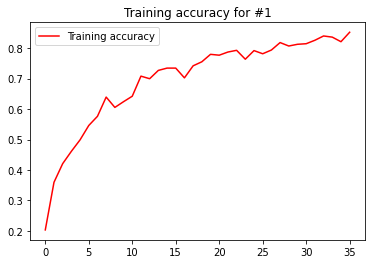

<Figure size 432x288 with 0 Axes>

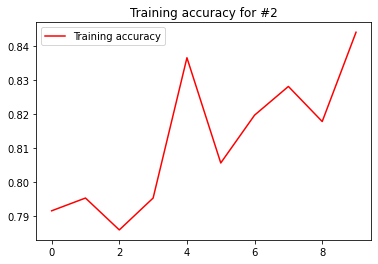

<Figure size 432x288 with 0 Axes>

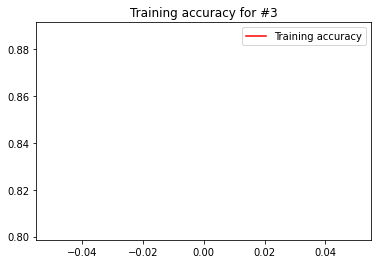

<Figure size 432x288 with 0 Axes>

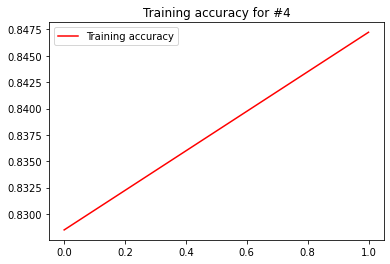

<Figure size 432x288 with 0 Axes>

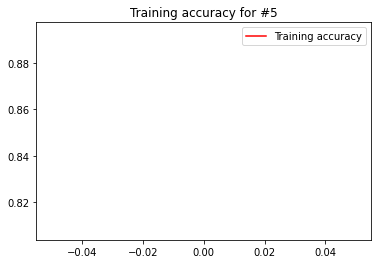

<Figure size 432x288 with 0 Axes>

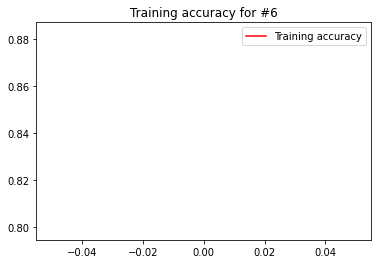

<Figure size 432x288 with 0 Axes>

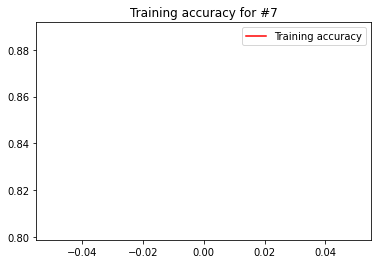

<Figure size 432x288 with 0 Axes>

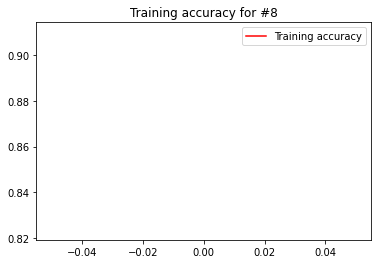

<Figure size 432x288 with 0 Axes>

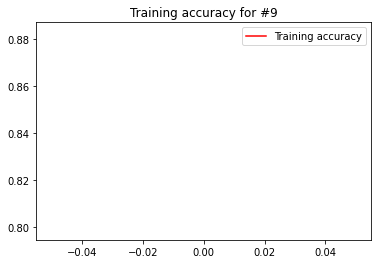

<Figure size 432x288 with 0 Axes>

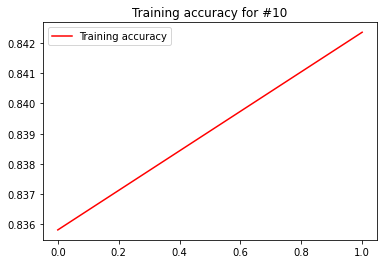

<Figure size 432x288 with 0 Axes>

In [21]:
n = 1
for history in histories:
  acc = history.history['accuracy']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.title(f'Training accuracy for #{n}')
  plt.legend(loc=0)
  plt.figure()

  plt.show()

  n += 1

##Exporting

In [22]:
model_incv3.save('/models')

INFO:tensorflow:Assets written to: /models/assets
